# Figure 6

Corresponds to Section 5 of the results, with a particular focus on the personalised retraining based on first cycle fits

In [1]:
import os
import sys
import json
import math
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import to_rgb
from matplotlib.cm import get_cmap

sys.path.append("../utils")
from myUtils import convert_ode_parameters, obtain_architecture,  TreatmentListToTS, ExtractTreatmentFromDf
from LotkaVolterraModel import LotkaVolterraModel
from plotUtils import plot_simulation

/home/gallagher/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

In [3]:
def convert_to_rgb_grayscale(col):
    rgb_col = to_rgb(col)
    return tuple([(0.2989 * rgb_col[0]) + (0.5870 * rgb_col[1]) + (0.1140 * rgb_col[2]) for _ in range(3)])

def redistribute_rgb(col):
    r, g, b = col
    threshold = 1 
    m = max(r, g, b)
    if m <= threshold:
        return r, g, b
    total = r + g + b
    if total >= 3 * threshold:
        return threshold, threshold, threshold
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return (gray + x * r), (gray + x * g), (gray + x * b)

/tmp/ipykernel_20742/222138803.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([''] + list(colors.keys()));


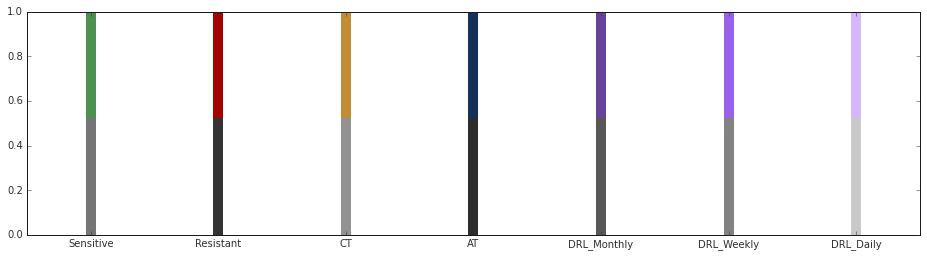

In [4]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

colors['DRL_Weekly'] = redistribute_rgb(tuple([1.5 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Daily'] = redistribute_rgb(tuple([2.0 * x for x in to_rgb(colors['DRL_Monthly'])]))

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for i, col in enumerate(colors.values()):
    plt.axvline(i+1, 0.5, 1, color = col, linewidth=10)
    plt.axvline(i+1, 0, 0.5, color = convert_to_rgb_grayscale(col), linewidth=10)
plt.xlim(0.5, len(colors.values()) + 0.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().set_xticklabels([''] + list(colors.keys()));

In [5]:
file_path = os.path.dirname(os.path.abspath("__file__"))
dev_path = os.path.join(file_path, os.pardir, "demo")
print(dev_path)

/home/gallagher/Documents/rotation_project/ML_driven_tx/paper_figures/../demo


## Characterising fits

In [6]:
def PlotDrug(dataDf, ax, color, plotDrugAsBar=True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, **kwargs):
    # Generate drug data as time series from list
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    # Optional moving average of drug value
    # drugConcentrationVec = np.array(pd.Series(drugConcentrationVec).rolling(10).mean())
    # drugConcentrationVec = np.nan_to_num(drugConcentrationVec)

    if not plotDrugAsBar: # Plot as bands that run down the full size of the figure.
        ax.fill_between(x=dataDf['Time'], y1=ax.get_ylim()[0], y2=drugConcentrationVec, linewidth=0.0,
                         alpha=0.25, step="post", label="Drug Concentration", color=color, **kwargs)

    else: # Plot as bars across top of plot. Cleaner, but can be harder to see alignment with tumour trajectory.
        # Rescale to make it fit within the bar at the top of the plot
        drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
        ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                         alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
        ax.hlines(xmin=dataDf['Time'].min(), xmax=dataDf['Time'].max(),
                  y=currDrugBarPosition, linewidth=3, color="black")
        # Line at the top of the drug bars
        ax.hlines(xmin=dataDf['Time'].min(), xmax=dataDf['Time'].max(),
                      y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")


In [7]:
def PlotData(dataDf, ax, feature='PSA', drugBarPosition=0.85,
             xlim=2e3, ylim=1.3, y2lim=1, markersize=10, color = 'Black'):
    # Plot the data
    ax.plot(dataDf.Time, dataDf[feature],
            linestyle="None", marker="+", markersize=markersize,
            color=color, markeredgewidth=2)

    PlotDrug(dataDf, ax, "k", plotDrugAsBar = True)

    # # Format the plot
    ax.set_xlim(0,xlim); ax.set_ylim(0, ylim)
    ax.set_xticks(np.linspace(0, xlim, 5))
    ax.tick_params(right = False, top = False)
    


In [8]:
def SimulateFit(fit_params, dataDf, dt=1, solver_kws={}):
    myModel = LotkaVolterraModel()
    myModel.SetParams(**fit_params)
    myModel.Simulate(treatmentScheduleList=ExtractTreatmentFromDf(dataDf),**solver_kws)
    # Interpolate to the desired time grid
    t_eval = np.arange(0, myModel.resultsDf.Time.max(), dt)
    trimmedResultsDic = {'Time': t_eval}
    for variable in ['S', 'R', 'TumourSize', 'DrugConcentration']:
        f = sc.interpolate.interp1d(myModel.resultsDf.Time, myModel.resultsDf[variable])
        trimmedResultsDic = {**trimmedResultsDic, variable: f(t_eval)}
    myModel.resultsDf = pd.DataFrame(trimmedResultsDic)
    return myModel

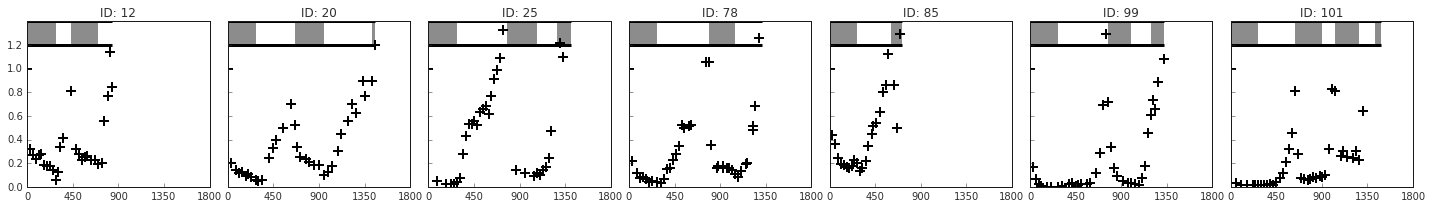

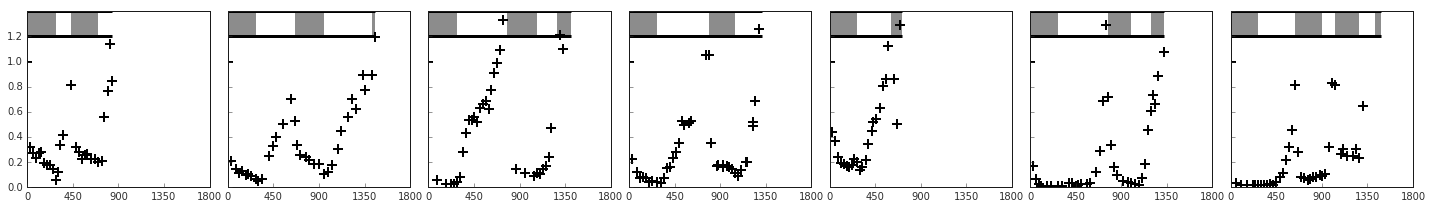

In [13]:
data_dir = "Prog_data" #"Prog_truncated_data_n1"

fit_dirs = ["fits_firstCycle_n0_turnover", "fits_firstCycle_n0_turnover_noResistance"]

for n, fit_dir in enumerate(fit_dirs):
    dataToAnalyse = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", fit_dir, "fitSummaryDf.csv"))

    # Plot all fits
    fig, axList = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(20, 3))
    for i, patientId in enumerate(sorted(dataToAnalyse.PatientId.unique())):
        patient_data = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", data_dir, "patient%s.csv"%"{:03d}".format(patientId)))
        patient_data.rename(columns = {'Days': 'Time', 'Abi': 'DrugConcentration'}, inplace = True)
        # patient_data['Time'] = patient_data['Days']
        # patient_data['DrugConcentration'] = patient_data['Abi']

        # patient_params = dataToAnalyse[dataToAnalyse['PatientId'] == int(patientId)].iloc[0].to_dict()
        # fit_df = SimulateFit(patient_params, patient_data).resultsDf
        # axList.flatten()[i].plot(fit_df['Time'], fit_df['TumourSize']/patient_params['n0'], linewidth=5)
        # axList.flatten()[i].yaxis.get_major_t
        if n == 0:
            axList.flatten()[i].set_title("ID: " + str(patientId))

        PlotData(patient_data, feature = 'relPSA_Indi', ax=axList.flatten()[i], xlim = 1.8e3, ylim=1.4)

    axList.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
    axList.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive
/home/gallagher/Documents/rotation_project/ML_driven_tx/paper_figures/../utils/odeModelClass.py:263: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/tmp/ipykernel_2189211/2960158217.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/home/gallagher/Documents/rotation_project/ML_driven_tx/paper_figures/../utils/odeModelClass.py:263: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/tmp/ipykernel_2189211/2960158217.py:20: UserWarning: Tight layout not applied.

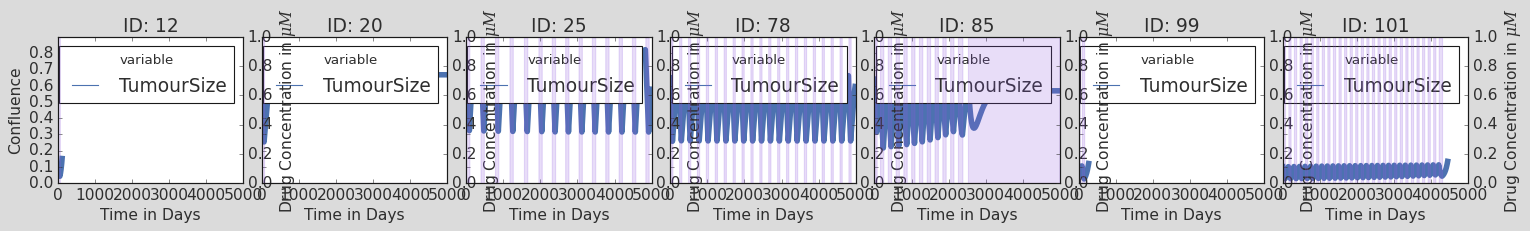

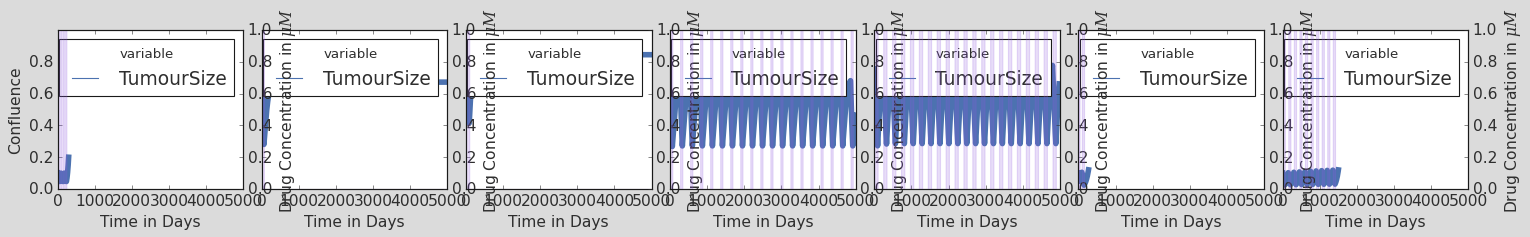

In [56]:
for n, fit_dir in enumerate(fit_dirs):
    dataToAnalyse = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", fit_dir, "fitSummaryDf.csv"))

    # Plot all fits
    fig, axList = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(20, 3))
    for i, patientId in enumerate(sorted(dataToAnalyse.PatientId.unique())):
        patient_data = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", data_dir, "patient%s.csv"%"{:03d}".format(patientId)))
        patient_data.rename(columns = {'Days': 'Time', 'Abi': 'DrugConcentration'}, inplace = True)

        patient_params = dataToAnalyse[dataToAnalyse['PatientId'] == int(patientId)].iloc[0].to_dict()
        myModel = LotkaVolterraModel(); myModel.SetParams(**patient_params)
        myModel.Simulate_AT(atThreshold=0.5, intervalLength=30, t_end=5000)
        myModel.Plot(ax = axList.flatten()[i])

        if n == 0:
            axList.flatten()[i].set_title("ID: " + str(patientId))

    axList.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
    axList.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

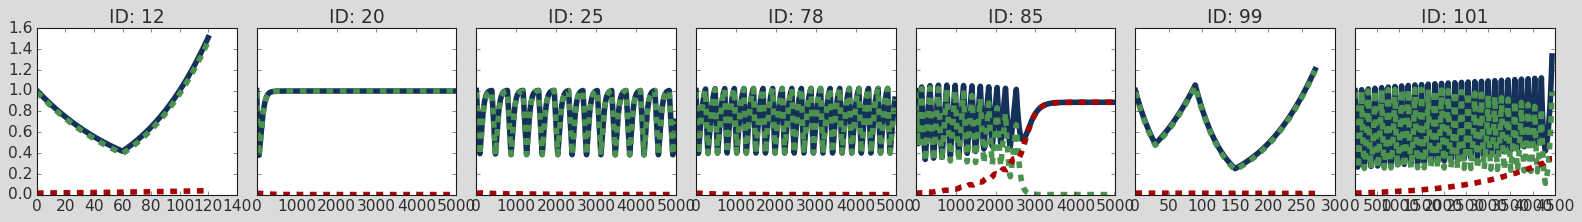

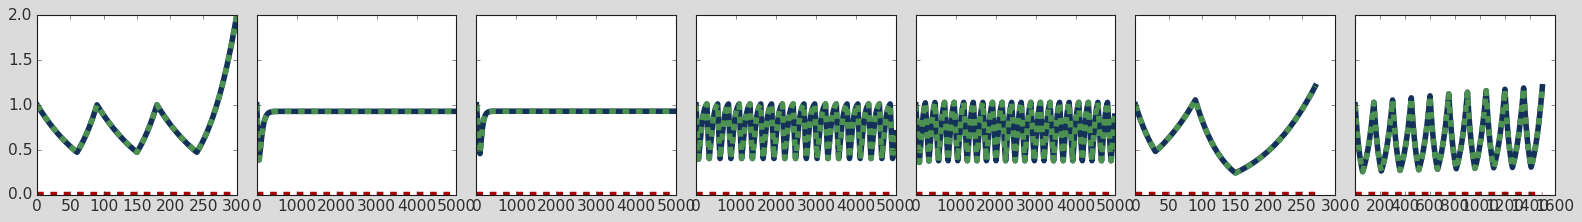

In [11]:
for n, fit_dir in enumerate(fit_dirs):
    dataToAnalyse = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", fit_dir, "fitSummaryDf.csv"))

    # Plot all fits
    fig, axList = plt.subplots(1, 7,sharey=True, figsize=(20, 3))
    for i, patientId in enumerate(sorted(dataToAnalyse.PatientId.unique())):
        patient_data = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", data_dir, "patient%s.csv"%"{:03d}".format(patientId)))
        patient_data.rename(columns = {'Days': 'Time', 'Abi': 'DrugConcentration'}, inplace = True)

        patient_params = dataToAnalyse[dataToAnalyse['PatientId'] == int(patientId)].iloc[0].to_dict()
        myModel = LotkaVolterraModel(); myModel.SetParams(**patient_params)
        myModel.Simulate_AT(atThreshold=0.5, intervalLength=30, t_end=5000)
        
        linestyles = ['-', '--', '--']; palette = {'TumourSize': colors['AT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
        for j, var in enumerate(["TumourSize", 'S', 'R']):
            axList.flatten()[i].plot(myModel.resultsDf['Time'], myModel.resultsDf[var] / patient_params['n0'], linewidth=5, linestyle=linestyles[j], color=palette[var])

        if n == 0:
            axList.flatten()[i].set_title("ID: " + str(patientId))

    # axList.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
    # axList.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

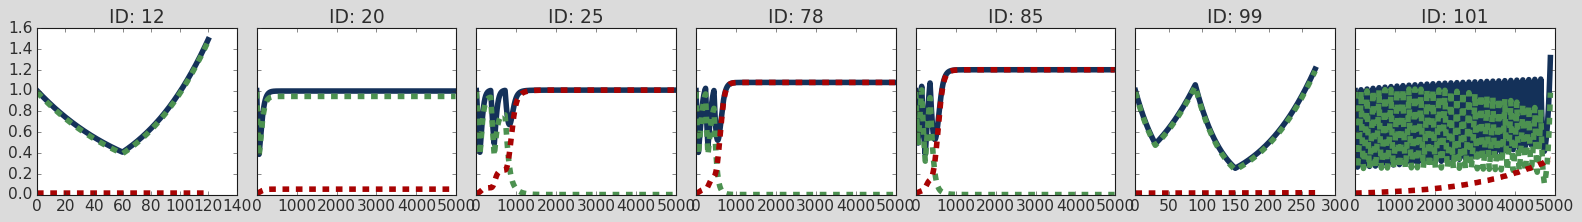

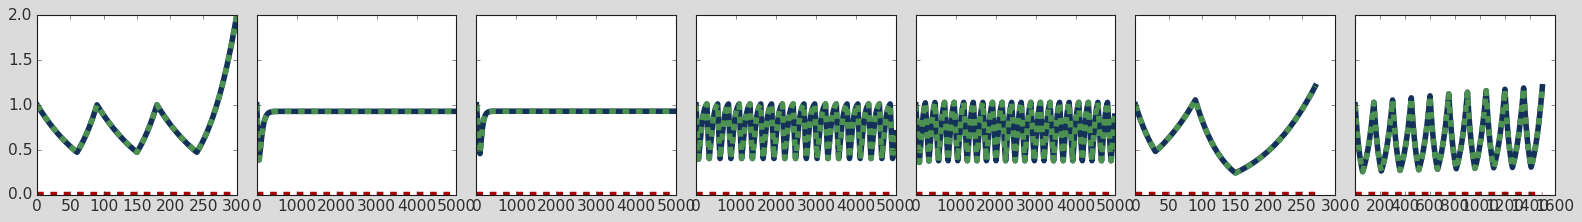

In [12]:
for n, fit_dir in enumerate(fit_dirs):
    dataToAnalyse = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", fit_dir, "fitSummaryDf.csv"))

    # Plot all fits
    fig, axList = plt.subplots(1, 7,sharey=True, figsize=(20, 3))
    for i, patientId in enumerate(sorted(dataToAnalyse.PatientId.unique())):
        patient_data = pd.read_csv(os.path.join(dev_path, "patients/Bruchovsky_et_al", data_dir, "patient%s.csv"%"{:03d}".format(patientId)))
        patient_data.rename(columns = {'Days': 'Time', 'Abi': 'DrugConcentration'}, inplace = True)

        patient_params = dataToAnalyse[dataToAnalyse['PatientId'] == int(patientId)].iloc[0].to_dict()
        cost = max(0, 1 - (patient_params['turnover'] / (1 - (1.2 * patient_params['n0']) / patient_params['k'])))
        mod_params = convert_ode_parameters(n0=patient_params['n0'], rFrac=patient_params['R0']/patient_params['n0'], cost=cost, turnover=patient_params['turnover'])
        myModel = LotkaVolterraModel(); myModel.SetParams(**mod_params)
        myModel.Simulate_AT(atThreshold=0.5, intervalLength=30, t_end=5000)
        
        linestyles = ['-', '--', '--']; palette = {'TumourSize': colors['AT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
        for j, var in enumerate(["TumourSize", 'S', 'R']):
            axList.flatten()[i].plot(myModel.resultsDf['Time'], myModel.resultsDf[var] / patient_params['n0'], linewidth=5, linestyle=linestyles[j], color=palette[var])

        if n == 0:
            axList.flatten()[i].set_title("ID: " + str(patientId))

    # axList.flatten()[0].yaxis.get_major_ticks()[-1].set_visible(False);
    # axList.flatten()[2].yaxis.get_major_ticks()[-1].set_visible(False);
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [15]:
def check_prog_occurs(cost, turnover, n0, K, **kwargs):
    limit = (1 - (1.2 * n0) / K) * (1 - cost)
    return turnover < limit

def test_fit(fit_dir):
    try:
        df = pd.read_csv(os.path.join(fit_dir, "fitSummaryDf.csv"))
    except FileNotFoundError as e:
        print(f"No summary file found for subdir {os.path.basename(fit_dir)} in dir {str(e).split(': ')[-1]}")
        return
    
    df['Prog'] = df.apply(lambda row: check_prog_occurs(**row, K = row['k']), axis=1)
    print(f"{os.path.basename(fit_dir)}: {sorted([id for id in df.PatientId.unique() if (df[df.PatientId == id].Prog.all())])}") #  
    


fit_dirs = ["fits_firstCycle_n0_turnover", "fits_firstCycle_n0_turnover_noResistance"]

for fit_dir in fit_dirs:
    test_fit(os.path.join(dev_path, "patients/Bruchovsky_et_al", fit_dir))

fits_firstCycle_n0_turnover: [12, 101]
fits_firstCycle_n0_turnover_noResistance: [12, 101]


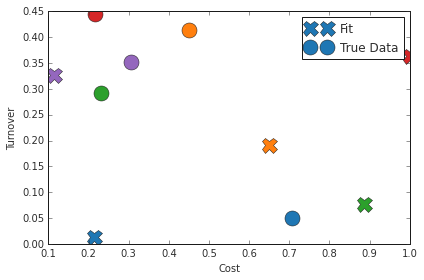

In [22]:
fitting_name = '5params_Capacity'
fit_dir = "patients/Bruchovsky_et_al/Prog_truncated_fits"
fits_df = pd.read_csv(os.path.join(dev_path, fit_dir, fitting_name, "fitPatientsDf_all.csv"))
true_df = pd.read_csv(os.path.join(dev_path, os.pardir, "models/trainingPatientsDf_bruchovsky.csv"))

fits_df['K'] = fits_df['k']; true_df['K'] = true_df['k']

def make_label(name, i):
    return name if i == 0 else ''

cmap = plt.get_cmap("tab10")
for i, id in enumerate(sorted(fits_df.PatientId.unique())):
    plt.plot(fits_df[fits_df.PatientId==id].cost, fits_df[fits_df.PatientId==id].turnover, linestyle='', marker = 'X', color = cmap(i), markersize=15, label=make_label("Fit", i))
    plt.plot(true_df[true_df.PatientId==id].cost, true_df[true_df.PatientId==id].turnover, linestyle='', marker = 'o', color = cmap(i), markersize=15, label=make_label("True Data", i))
    
plt.xlabel('Cost'); plt.ylabel('Turnover');
plt.legend(); plt.tight_layout();
# plt.savefig("../paper_figures/figures/fig5app_fitting_errors.png")

In [171]:
# Plot an example trajectory (simulated) from fitted and real trajectories - for p25
fit_dfs = [true_df, fits_df]
param_sets = []
outputs = []

for df in fit_dfs:
    params = df[df.PatientId==99]
    param_dict = params.to_dict(orient = 'list')
    param_sets.append({key: value[0] for key, value in param_dict.items()})

for params in param_sets:
    model = LotkaVolterraModel(method='RK45')
    model.SetParams(**params)
    model.Simulate_AT(atThreshold=0.5, intervalLength=14, t_end=5000);
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= params['n0'];
    outputs.append(model.resultsDf)

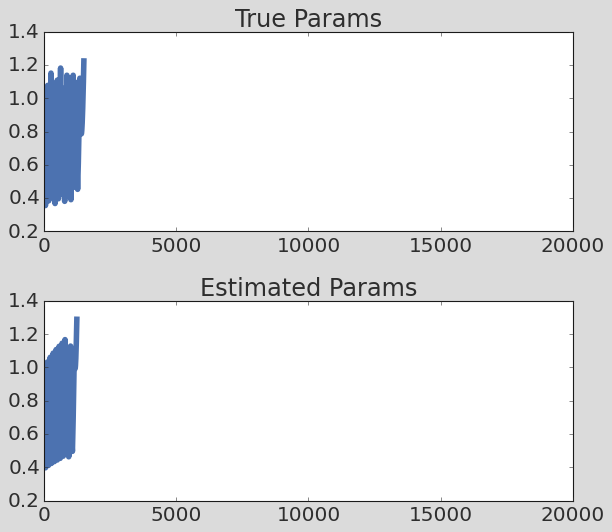

In [172]:
fig, axs = plt.subplots(2, 1,figsize=(8,7))

for i, output in enumerate(outputs):
    axs[i].plot(output['Time'], output['TumourSize'], linewidth=5, linestyle=['-', '-'][i])
    axs[i].set_xlim(0, 20000); axs[i].set_title(['True Params', 'Estimated Params'][i])
    
plt.tight_layout()
# plt.savefig("../paper_figures/figures/fig5app_fitted_params.png")

## Results for single cycle params

In [239]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(file_path, os.pardir, "models")
results_path = os.path.join(file_path, "data", "Fig5")
runFromScratch = True

trainingDataDf = pd.read_csv("../models/trainingPatientsDf_bruchovsky.csv", index_col=0)
# trainingDataDf.loc[39, 'turnover'] *= 1.5
eval_df = trainingDataDf.rename(columns={'fR':'rFrac'}).apply(lambda row: pd.Series(convert_ode_parameters(**row)), axis=1)
eval_df['PatientId'] = trainingDataDf.apply(lambda row: int(trainingDataDf.loc[row.name]['PatientId']), axis=1)

model_base_name = 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id'
patient_models = {patient_id: model_base_name + str(patient_id) for patient_id in sorted(trainingDataDf.PatientId.unique())}

alt_base_name = 'test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id'; alt_ids = [85]
for alt_id in alt_ids:
    patient_models[alt_id] = alt_base_name + str(alt_id)
print(patient_models)

# Taken from successful trainings, labelling errors but all models are monthly

max_epochs = {id: int(max([f.name.split('_')[0] for f in os.scandir(os.path.join(model_path, patient_models[id])) if f.is_dir() and f.name.endswith(patient_models[id])]))
              for id in patient_models.keys()}
print(max_epochs)

updating_interval = 14; t_max = 5000
n_replicates = 20

{12: 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id12', 20: 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id20', 25: 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id25', 78: 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id78', 85: 'test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id85', 99: 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id99', 101: 'test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id101'}
{12: 140000, 20: 140000, 25: 140000, 78: 140000, 85: 140000, 99: 140000, 101: 140000}


In [242]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop

for patient_id, model_name in patient_models.items():
    n_epochs = max_epochs[patient_id]
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':eval_df[eval_df['PatientId']==patient_id].to_dict(),
              'architecture_kws':obtain_architecture(model_name),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig5", "params", "params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, patient_id))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            # print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, patient_id)
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)), index_col=0)

/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_12.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_20.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_25.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_78.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_85.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_99.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_14_101.json


test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id12
test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id20
test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id25
test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id78
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id85
test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id99
test_currSizeOnly_step2_biweekly_trunc_Bruchovsky_adapted_fit2_id101


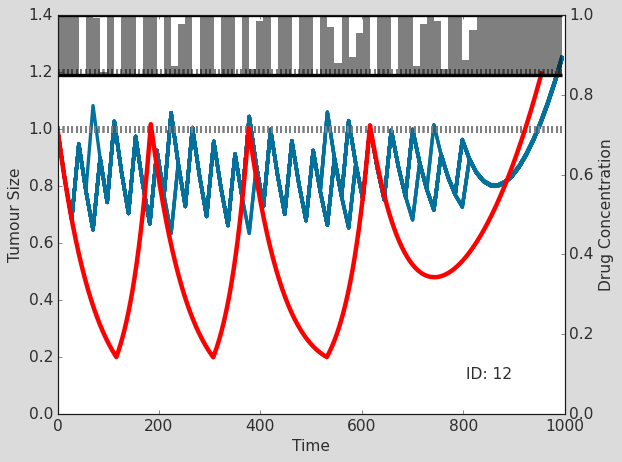

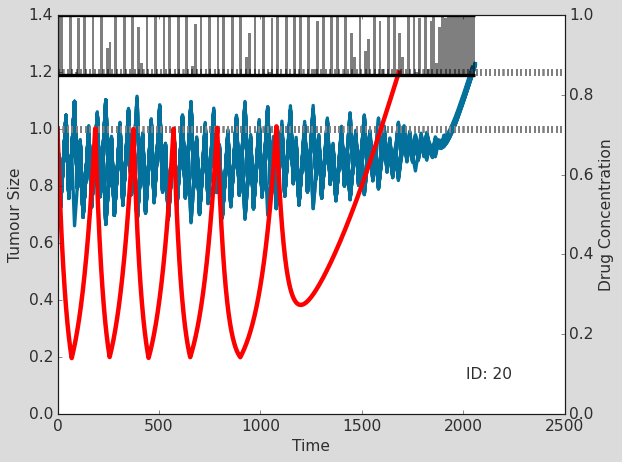

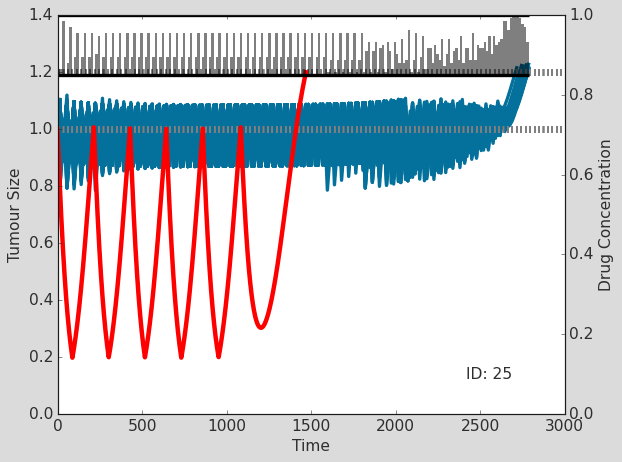

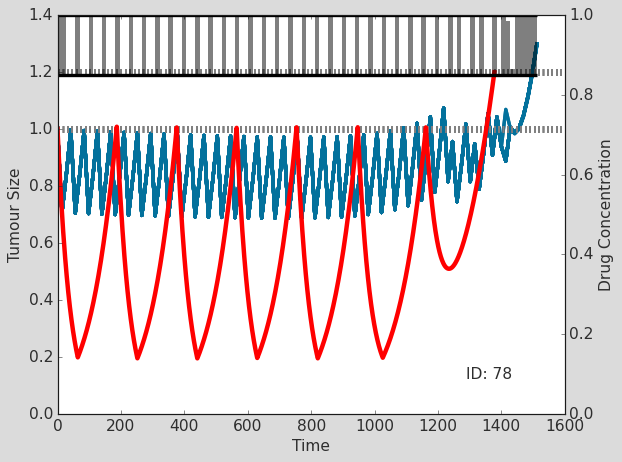

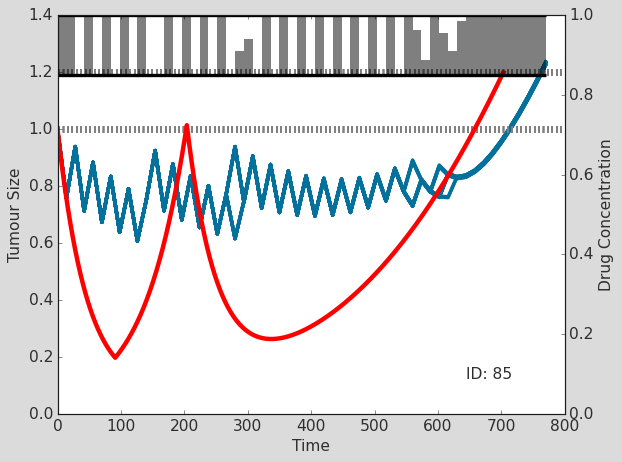

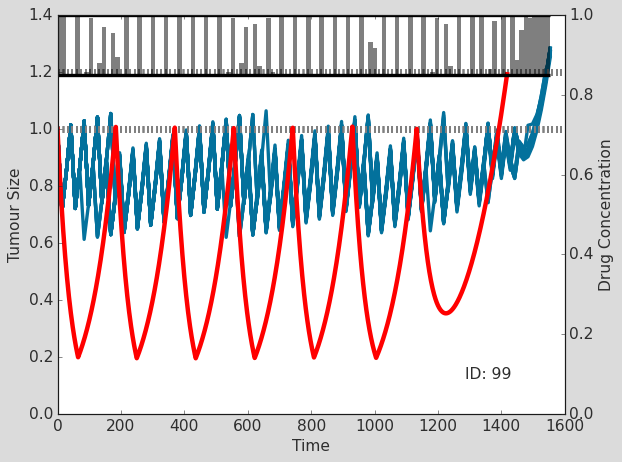

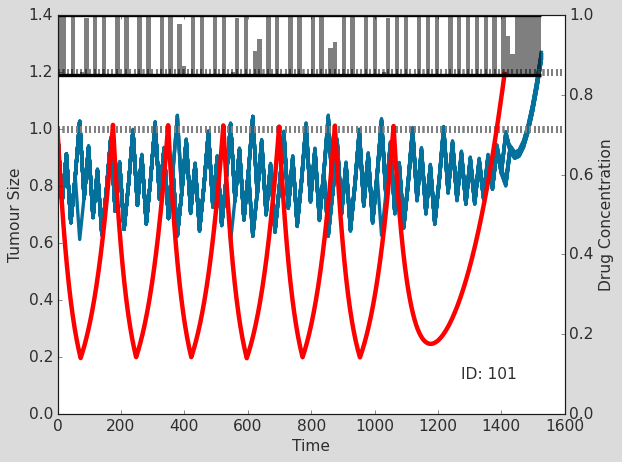

In [243]:
for patient_id, model_name in patient_models.items():
    trainingDataDf_id = trainingDataDf[trainingDataDf.PatientId==int(patient_id)]
    odeParamDic_id = convert_ode_parameters(trainingDataDf_id['n0'].values[0],trainingDataDf_id['fR'].values[0],
                                         trainingDataDf_id['cost'].values[0],trainingDataDf_id['turnover'].values[0])
    model_id = LotkaVolterraModel(method='RK45'); model_id.SetParams(**odeParamDic_id)
    model_id.Simulate_AT(atThreshold=0.8, intervalLength=1, t_end=5000, solver_kws = {'dt':1}); model_id.Trim(dt=1)
    model_id.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic_id['n0'];
    
    print(model_name)
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name, max_epochs[patient_id], updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= currDataDf['TumourSize'][0]
    # Plot average trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,6))
    plot_simulation(currDataDf[currDataDf['PatientId'] == patient_id], plotPops=False, lineplot_kws={'estimator':None, 'units':"ReplicateId"},
                    markInitialSize=True, markProgression=True, ax=ax)
    ax.plot(model_id.resultsDf.Time, model_id.resultsDf.TumourSize, lw=4, color='red')
    ax.text(0.85, 0.1, 'ID: %s'%patient_id, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [244]:
tmpList = []
for patient_id, model_name in patient_models.items():
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name, max_epochs[patient_id], updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    currDataDf['TumourSize'] = currDataDf.apply(lambda row: row['TumourSize'] / trainingDataDf[trainingDataDf.PatientId==row['PatientId']]['n0'].values[0], axis=1)
    currDataDf['n_epochs'] = max_epochs[patient_id]
    tmpList.append(currDataDf)
policyDf = pd.concat(tmpList)

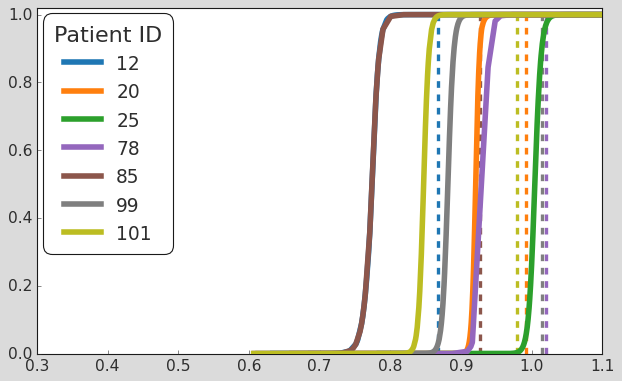

In [245]:
# Plot learned policies

n = len(trainingDataDf['PatientId'].unique())
cols = [get_cmap('tab10')(i/n) for i in range(n)]
markers = ['v', 's', 'X', 'P', 'o', '*', 'd',]

trainingDataDf['K'] = trainingDataDf['k']
updating_interval = 14

fix, ax = plt.subplots(1,1,figsize=(8,5))
for i, patient_id in enumerate(np.sort(policyDf['PatientId'].unique())):
    n0 = trainingDataDf[trainingDataDf.PatientId==patient_id]['n0'].values[0]
    # ax.plot(policyDf[policyDf['PatientId']==patient_id]['TumourSize'], policyDf[policyDf['PatientId']==patient_id]['Support_Treat'], 
    #          marker = '.', linestyle = '', label = patient_id, color = cols[i])
    df = policyDf[policyDf['PatientId']==patient_id].sort_values('TumourSize')
    # df = df[df['TumourSize'] < 1.03]
    ax.plot(df['TumourSize'], df['Support_Treat'], linestyle = '-', linewidth=5, zorder=(patient_id), color = cols[i], label = patient_id)
    
ax.set_ylim(0,1.02); ax.set_xlim(0.3, 1.1); ax.tick_params(top=False, right=False)
plt.legend(numpoints=1, title = 'Patient ID', title_fontsize=20, loc= 2).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.tight_layout();

In [246]:
def generate_stats(final_states):
    stats_df = final_states.groupby(['PatientId'])['Time'].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []

    for i in stats_df.index:
        m, c, s = stats_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))  # For 95% confidence interval
        ci95_lo.append(m - 1.96*s/math.sqrt(c))

    stats_df['ci95_hi'] = ci95_hi
    stats_df['ci95_lo'] = ci95_lo
    return stats_df

In [247]:
patient_list = []
for patient_id, model_name in sorted(patient_models.items()):
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name, max_epochs[patient_id], updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= currDataDf['TumourSize'][0]
        
    final_states = currDataDf.drop_duplicates(subset=['PatientId', 'ReplicateId'], keep='last')
    patient_stats = generate_stats(final_states)
    if patient_stats.index.name == "PatientId":
        patient_stats.reset_index(inplace=True)
    patient_list.append(patient_stats)
    
stats_df = pd.concat(patient_list)
# stats_df['ATProgression'] = stats_df["PatientId"].apply(func=progression_time_mtd, args = (eval_df, 1, t_max))

In [248]:
group_model_name = 'test_currSizeOnly_bruchovsky_group_monthly'; group_n_epochs = 150000
results_file_name = 'resultsDf_%s_crBase_%d_patients.csv'%(group_model_name,group_n_epochs)
group_df = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        
final_group_df = group_df.drop_duplicates(subset=['PatientId', 'ReplicateId'], keep='last')
group_stats = generate_stats(final_group_df)

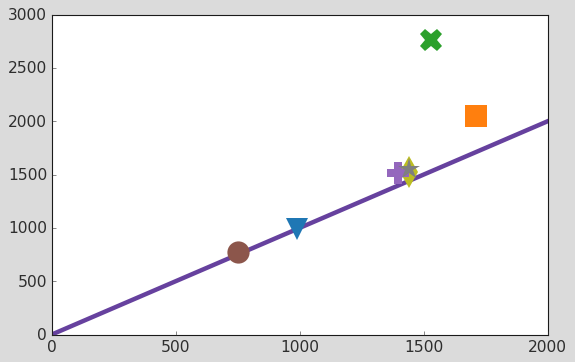

In [249]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
    df = stats_df[stats_df.PatientId == patient_id] 
    ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))
    
plt.plot([0, max(stats_df['mean'])], [0, max(stats_df['mean'])], linestyle = '-', linewidth = 4, zorder=0, color=colors['DRL_Monthly'])
ax.set_xlim(0, 2000), ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)

In [250]:
def calc_ttp(ID, params_path = "../models/trainingPatientsDf_bruchovsky.csv", method = 'ROT', updating_interval=1):
    # Calculate analytic TTP using either Rule Of Thumb (ROT) or Maximum Tolerated Dose (MTD) strategies
    model = LotkaVolterraModel(method='RK45')
    paramDic = {**model.GetParams(params_path, "number", id=ID)}
    model.SetParams(**paramDic)
    if method == 'ROT':
        model.Simulate_AT(atThreshold=0.5, intervalLength=updating_interval, t_end=5000)
        model.Trim(dt=1)
        return model.ttp
    elif method == 'MTD':
        model.Simulate([[0, 4000, 1]])
        return max(model.resultsDf[model.resultsDf.TumourSize < 1.2 * model.resultsDf.TumourSize[0]].Time)
    else:
        raise ValueError('Unknown treatment protocol - should be either \'ROT\' or \'MTD\'')


In [251]:
perfect_at_list = [calc_ttp(i, updating_interval=1) for i in sorted(patient_models.keys())]
biweekly_at_list = [calc_ttp(i, updating_interval=14) for i in sorted(patient_models.keys())]
weekly_at_list = [calc_ttp(i, updating_interval=7) for i in sorted(patient_models.keys())]
monthly_at_list = [calc_ttp(i, updating_interval=30) for i in sorted(patient_models.keys())]
ct_list = [calc_ttp(i, method='MTD') for i in sorted(patient_models.keys())]

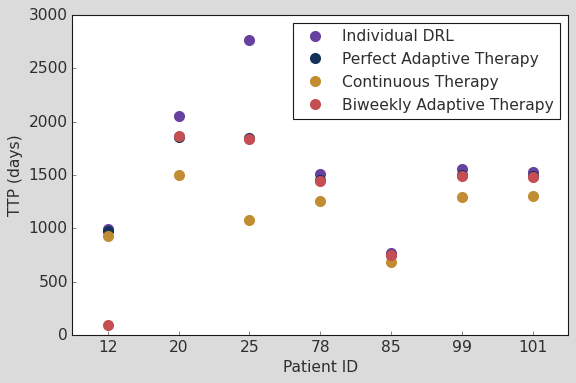

In [252]:
n = len(patient_models.keys())

fig, ax = plt.subplots(1,1,figsize=(8,5))
# for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
#     df = stats_df[stats_df.PatientId == patient_id] 
#     ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))

plot_style = {'marker': '.', 'markersize': 20, 'markeredgewidth': 0, 'linestyle': ''}
    
plt.plot(range(n), stats_df['mean'], label = "Individual DRL", color=colors["DRL_Monthly"], **plot_style) #, zorder=5)
# plt.plot(range(n), group_stats['mean'], label = "Group DRL", color='g', **plot_style)
plt.plot(range(n), perfect_at_list, label = "Perfect Adaptive Therapy", color=colors['AT'], **plot_style)
plt.plot(range(n), ct_list, label = "Continuous Therapy", color=colors['CT'], **plot_style)
plt.plot(range(n), biweekly_at_list, label = "Biweekly Adaptive Therapy", color='r', **plot_style)

ax.set_xticks(range(n), patient_models.keys())
    
ax.set_xlim(-0.5, 6.5), ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)
ax.set_xlabel("Patient ID"); ax.set_ylabel("TTP (days)"); plt.legend(loc=1, fontsize=14, numpoints=1)
plt.savefig("../paper_figures/figures/fig5_indvperf_benchmarks.png")

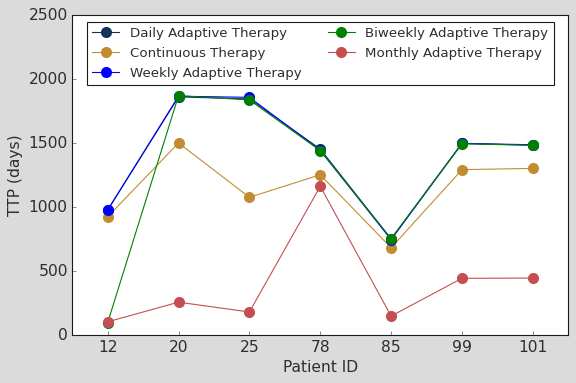

In [253]:
n = len(patient_models.keys())

fig, ax = plt.subplots(1,1,figsize=(8,5))
# for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
#     df = stats_df[stats_df.PatientId == patient_id] 
#     ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))

plot_style = {'marker': '.', 'markersize': 20, 'markeredgewidth': 0, 'linestyle': '-', 'alpha': 1}
    

plt.plot(range(n), perfect_at_list, label = "Daily Adaptive Therapy", color=colors['AT'], **plot_style)
plt.plot(range(n), ct_list, label = "Continuous Therapy", color=colors['CT'], **plot_style)
plt.plot(range(n), weekly_at_list, label = "Weekly Adaptive Therapy", color='blue', **plot_style)
plt.plot(range(n), biweekly_at_list, label = "Biweekly Adaptive Therapy", color='green', **plot_style)
plt.plot(range(n), monthly_at_list, label = "Monthly Adaptive Therapy", color='r', **plot_style)

ax.set_xticks(range(n), patient_models.keys())
    
ax.set_xlim(-0.5, 6.5), ax.set_ylim(0, 2500); ax.tick_params(top=False, right=False)
ax.set_xlabel("Patient ID"); ax.set_ylabel("TTP (days)"); plt.legend(loc=9, fontsize=12, numpoints=1, ncol=2)

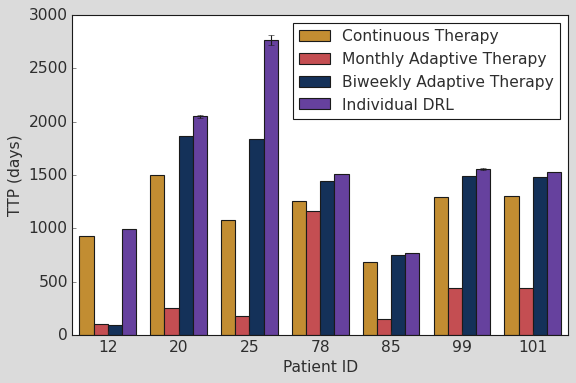

In [265]:
n = len(patient_models.keys())
ids = np.array(range(n))
bar_num = 4
width = (1-0.2) / bar_num


fig, ax = plt.subplots(1,1,figsize=(8,5))
# for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
#     df = stats_df[stats_df.PatientId == patient_id] 
#     ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))

plot_style = {'width': width}
    
plt.bar(ids - width * 1.5, ct_list, label = "Continuous Therapy", color=colors['CT'], **plot_style)
# plt.bar(ids - width * 0.5, [1001, 1488, 1418, 1337, 728, 1324, 1498], label = "Real TTP", color='pink', **plot_style)
plt.bar(ids - width * 0.5, monthly_at_list, label = "Monthly Adaptive Therapy", color='r', **plot_style)
plt.bar(ids + width * 0.5, biweekly_at_list, label = "Biweekly Adaptive Therapy", color=colors['AT'], **plot_style)
plt.bar(ids + width * 1.5, stats_df['mean'], label = "Individual DRL", color=colors["DRL_Monthly"], **plot_style)
ax.errorbar(ids + width * 1.5, stats_df['mean'], yerr=2*stats_df['std'], color='k', linestyle='', marker = '')

ax.set_xticks(range(n), patient_models.keys())
    
ax.set_xlim(-0.5, 6.5), ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)
ax.set_xlabel("Patient ID"); ax.set_ylabel("TTP (days)"); plt.legend(loc=1, fontsize=14, numpoints=1)
plt.savefig("../paper_figures/figures/fig5_indvperf_benchmark_bars.png")

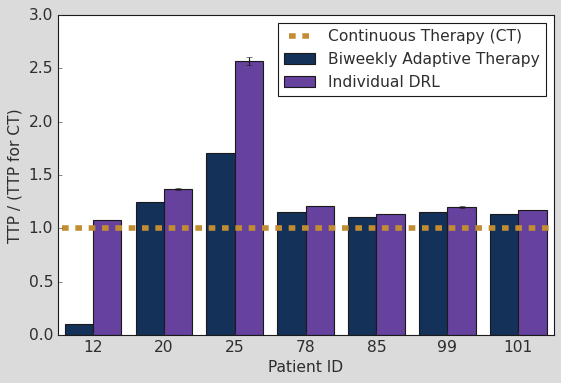

In [255]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
# for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
#     df = stats_df[stats_df.PatientId == patient_id] 
#     ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))
bar_num = 2; width = (1-0.2) / bar_num
plot_style = {'width': width}

ax.hlines(1, -1, 7, color=colors['CT'], linestyle = '--', linewidth=5, label = "Continuous Therapy (CT)")
plt.bar(ids - width * 0.5, [i / j for i, j in zip(biweekly_at_list, ct_list)], label = "Biweekly Adaptive Therapy", color=colors['AT'], **plot_style)
plt.bar(ids + width * 0.5, [i / j for i, j in zip(stats_df['mean'], ct_list)], label = "Individual DRL", color=colors["DRL_Monthly"], **plot_style)
ax.errorbar(ids + width * 0.5, [i / j for i, j in zip(stats_df['mean'], ct_list)], yerr=[2*i / j for i, j in zip(stats_df['std'], ct_list)], color='k', linestyle='', marker = '')


ax.set_xticks(range(n), patient_models.keys())
    
ax.set_xlim(-0.5, 6.5), ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)
ax.set_xlabel("Patient ID"); ax.set_ylabel("TTP / (TTP for CT)"); plt.legend(loc=1, fontsize=14, numpoints=1)
plt.savefig("../paper_figures/figures/fig5_indvperf_benchmark_barsb.png")

## Compare to the group retraining

In [256]:
model_name = 'test_currSizeOnly_bruchovsky_group_monthly'; n_epochs = 150000
updating_interval = 30; n_replicates = 10


currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
results_file_name = 'resultsDf_%s_crBase_%d_patients.csv'%(model_name,n_epochs)
argDic = {'model_path':currModel_path, 'patients_to_evaluate':eval_df.to_dict(),
          'architecture_kws':obtain_architecture(model_name),
          'n_replicates':n_replicates, 'updating_interval':updating_interval,
          'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
          'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
# To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
# to run it I made a separate environment. Use an external script to run the evaluation in that
# environment.
if runFromScratch:
    param_dir = os.path.join(file_path, "data", "Fig5", "params", "params_pCR_%s_%s.json"%(n_epochs, model_name))
    with open(param_dir, "w") as outfile:
        json.dump(argDic, outfile)
        print("Printed to JSON")
    command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_%s_%s.json"%(n_epochs, model_name)
    # p = subprocess.run(command, capture_output=True, shell=True)
    print(command)

    # Load results and process them
    dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
    # Extract TTP information
    tmpList = []
    for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
        ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
        tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
    ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
    ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients.csv"%(model_name,n_epochs)))
else:
    # Load results
    dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
    ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients.csv"%(model_name,n_epochs)), index_col=0)
        

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_150000_test_currSizeOnly_bruchovsky_group_monthly.json


In [257]:
results_file_name = 'resultsDf_%s_crBase_%d_patients.csv'%(model_name,n_epochs)
group_df = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        
final_group_df = group_df.drop_duplicates(subset=['PatientId', 'ReplicateId'], keep='last')
group_stats = generate_stats(final_group_df)

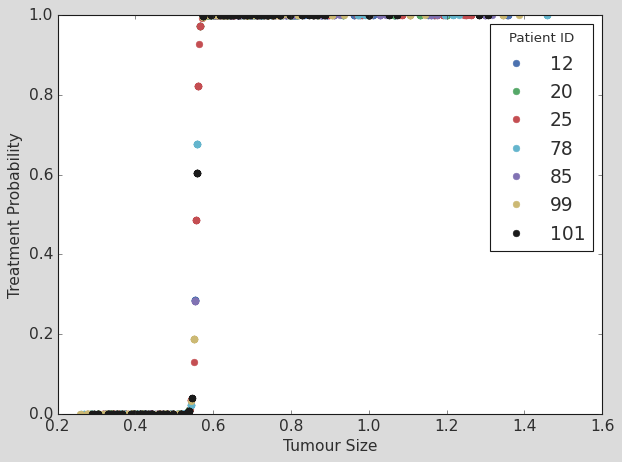

In [258]:
# Plot learned policies
fix, ax = plt.subplots(1,1,figsize=(8,6))
for id in np.sort(group_df['PatientId'].unique()):
    n0 = eval_df[eval_df.PatientId==id]['n0'].values[0]
    ax.plot(group_df[group_df['PatientId']==id]['TumourSize'] / n0, group_df[group_df['PatientId']==id]['Support_Treat'], 
             marker = '.', linestyle = '', label = id, markersize=12)
# ax.set_ylim(0,1.2); 
ax.set_ylabel('Treatment Probability'); ax.set_xlabel('Tumour Size')
plt.legend(numpoints=1, title = 'Patient ID'); plt.tight_layout(); 

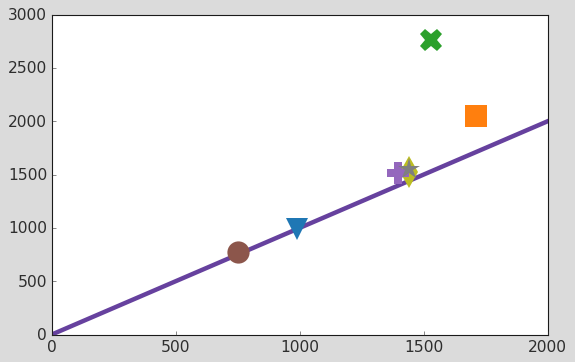

In [259]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
    df = stats_df[stats_df.PatientId == patient_id] 
    ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))
    
plt.plot([0, max(stats_df['mean'])], [0, max(stats_df['mean'])], linestyle = '-', linewidth = 4, zorder=0, color=colors['DRL_Monthly'])
ax.set_xlim(0, 2000), ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)

# plt.savefig("figures/fig5c_indv_eval.pdf")

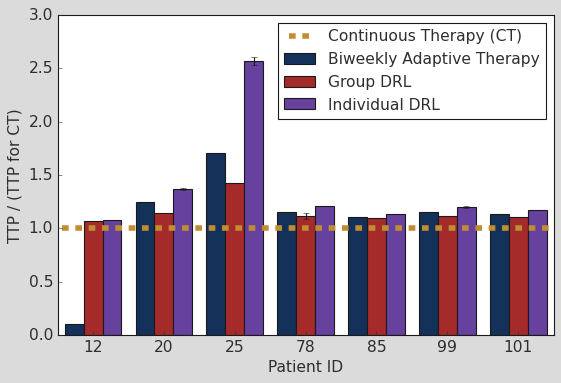

In [260]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
# for n, patient_id in enumerate(sorted(trainingDataDf['PatientId'].unique())):
#     df = stats_df[stats_df.PatientId == patient_id] 
#     ax.errorbar(x=group_stats.loc[patient_id]['mean'], y=df['mean'], yerr=df['std'], color = cols[n], marker = markers[n], markersize=20, markeredgewidth=0, zorder=(patient_id%5))
bar_num = 3; width = (1-0.2) / bar_num
plot_style = {'width': width}

ax.hlines(1, -1, 7, color=colors['CT'], linestyle = '--', linewidth=5, label = "Continuous Therapy (CT)")
plt.bar(ids - width * 1, [i / j for i, j in zip(biweekly_at_list, ct_list)], label = "Biweekly Adaptive Therapy", color=colors['AT'], **plot_style)
plt.bar(ids, [i / j for i, j in zip(group_stats['mean'], ct_list)], label = "Group DRL", color="brown", **plot_style)
plt.bar(ids + width * 1, [i / j for i, j in zip(stats_df['mean'], ct_list)], label = "Individual DRL", color=colors["DRL_Monthly"], **plot_style)
ax.errorbar(ids, [i / j for i, j in zip(group_stats['mean'], ct_list)], yerr=[2*i / j for i, j in zip(group_stats['std'], ct_list)], color='k', linestyle='', marker = '')
ax.errorbar(ids + width * 1, [i / j for i, j in zip(stats_df['mean'], ct_list)], yerr=[2*i / j for i, j in zip(stats_df['std'], ct_list)], color='k', linestyle='', marker = '')
    
ax.set_xlim(-0.5, 6.5); ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)
ax.set_xticks(range(len(ct_list)), patient_models.keys())
ax.set_xlabel("Patient ID"); ax.set_ylabel("TTP / (TTP for CT)"); plt.legend(loc=1, fontsize=14, numpoints=1)
plt.savefig("../paper_figures/figures/fig5_indvperf_benchmark_barsb.png")

## Compare to monthly indv training

In [266]:
model_base_name = 'test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id'
patient_models = {patient_id: model_base_name + str(patient_id) for patient_id in sorted(trainingDataDf.PatientId.unique())}

max_epochs = {id: int(max([f.name.split('_')[0] for f in os.scandir(os.path.join(model_path, patient_models[id])) if f.is_dir() and f.name.endswith(patient_models[id])]))
              for id in patient_models.keys()}
print(max_epochs)

updating_interval = 30; t_max = 5000
n_replicates = 20

{12: 140000, 20: 140000, 25: 140000, 78: 140000, 85: 140000, 99: 140000, 101: 140000}


In [276]:
for patient_id, model_name in patient_models.items():
    n_epochs = max_epochs[patient_id]
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':eval_df[eval_df['PatientId']==patient_id].to_dict(),
              'architecture_kws':obtain_architecture(model_name),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig5", "params", "params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, patient_id))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            # print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_%s_%s_%s.json"%(n_epochs, updating_interval, patient_id)
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)), index_col=0)

/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_12.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_20.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_25.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_78.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_85.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_99.json
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig5/params/params_pCR_140000_30_101.json


test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id12
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id20
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id25
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id78
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id85
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id99
test_currSizeOnly_step2_trunc_Bruchovsky_adapted_fit2_id101


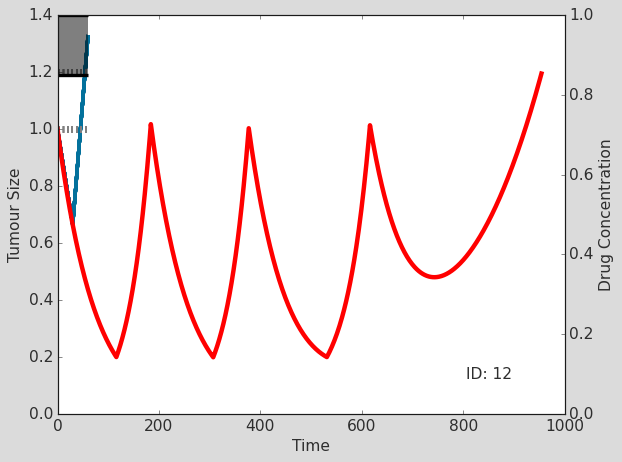

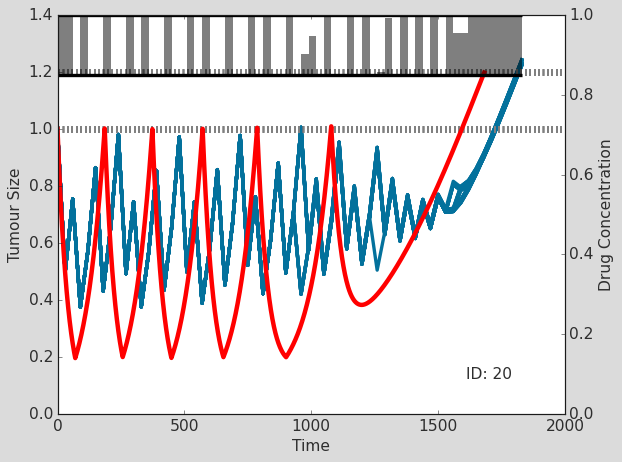

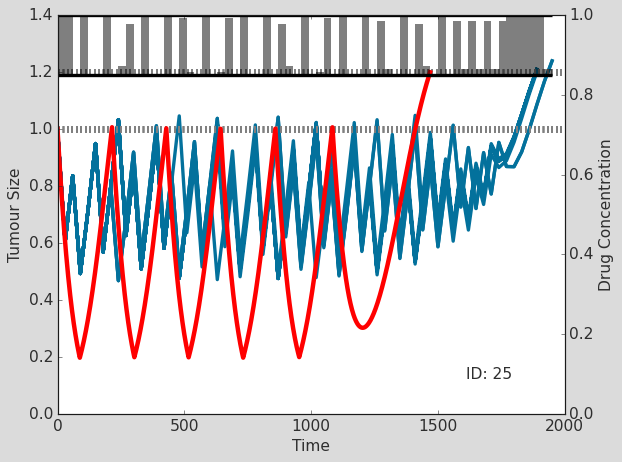

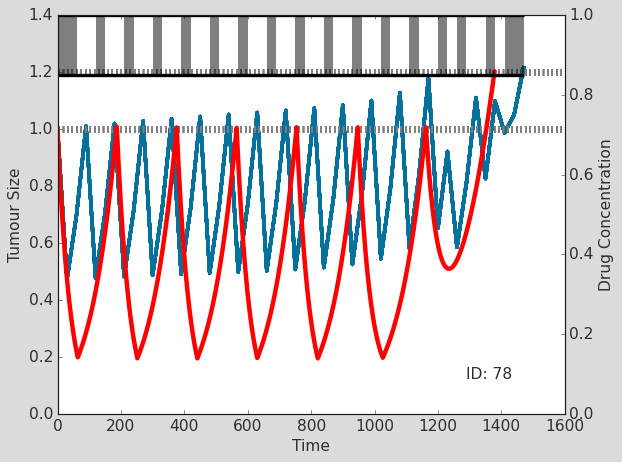

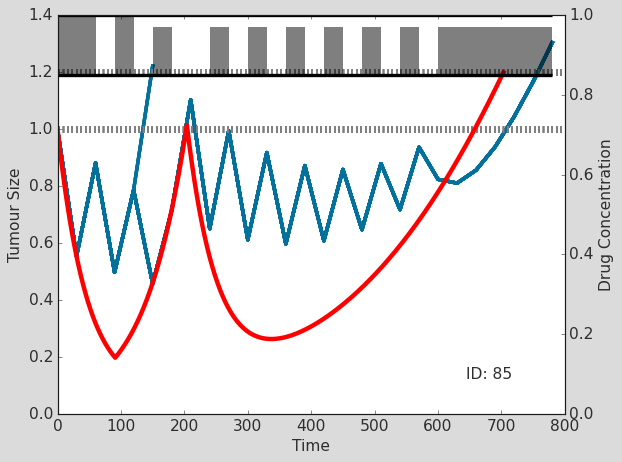

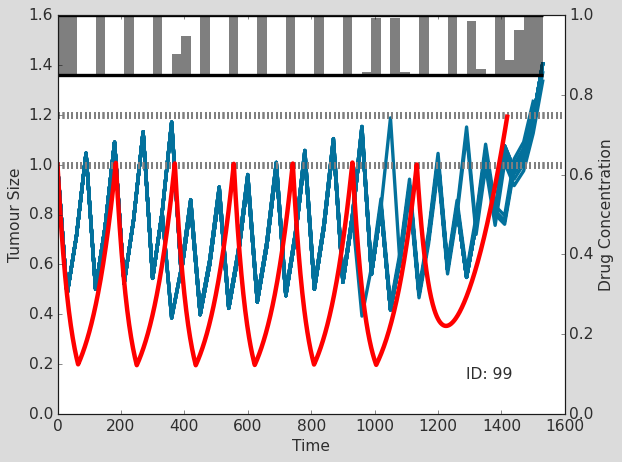

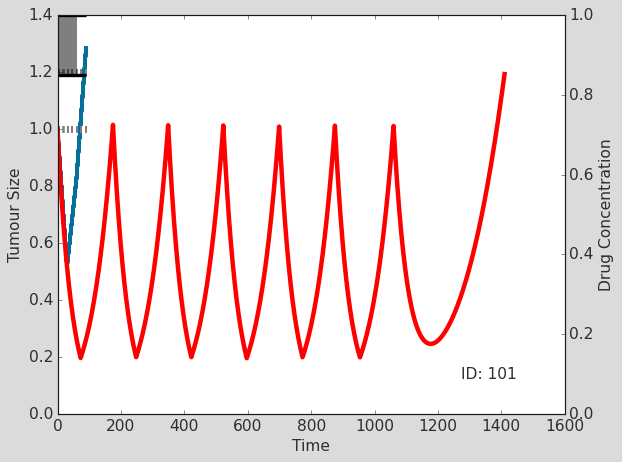

In [277]:
for patient_id, model_name in patient_models.items():
    trainingDataDf_id = trainingDataDf[trainingDataDf.PatientId==int(patient_id)]
    odeParamDic_id = convert_ode_parameters(trainingDataDf_id['n0'].values[0],trainingDataDf_id['fR'].values[0],
                                         trainingDataDf_id['cost'].values[0],trainingDataDf_id['turnover'].values[0])
    model_id = LotkaVolterraModel(method='RK45'); model_id.SetParams(**odeParamDic_id)
    model_id.Simulate_AT(atThreshold=0.8, intervalLength=1, t_end=5000, solver_kws = {'dt':1}); model_id.Trim(dt=1)
    model_id.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic_id['n0'];
    
    print(model_name)
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name, max_epochs[patient_id], updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= currDataDf['TumourSize'][0]
    # Plot average trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,6))
    plot_simulation(currDataDf[currDataDf['PatientId'] == patient_id], plotPops=False, lineplot_kws={'estimator':None, 'units':"ReplicateId"},
                    markInitialSize=True, markProgression=True, ax=ax)
    ax.plot(model_id.resultsDf.Time, model_id.resultsDf.TumourSize, lw=4, color='red')
    ax.text(0.85, 0.1, 'ID: %s'%patient_id, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [278]:
patient_list = []
for patient_id, model_name in sorted(patient_models.items()):
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name, max_epochs[patient_id], updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= currDataDf['TumourSize'][0]
        
    final_states = currDataDf.drop_duplicates(subset=['PatientId', 'ReplicateId'], keep='last')
    patient_stats = generate_stats(final_states)
    if patient_stats.index.name == "PatientId":
        patient_stats.reset_index(inplace=True)
    patient_list.append(patient_stats)
    
monthly_stats_df = pd.concat(patient_list)
# stats_df['ATProgression'] = stats_df["PatientId"].apply(func=progression_time_mtd, args = (eval_df, 1, t_max))

[-0.30000000000000004, -0.09999999999999995, 0.1, 0.30000000000000004, 0.5]


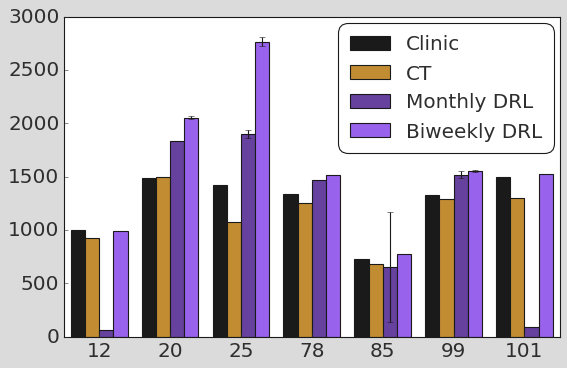

In [332]:
plt.rcParams['font.size'] = '18'

n = len(patient_models.keys())
ids = np.array(range(n))
bar_num = 4
space_widths = 1
width = 1 / (bar_num + space_widths)
offsets = [width * (i + 0.5 * space_widths) - 0.5 for i in range(bar_num + 1)]  # odd 
offsets = [width * (i + 0.5 * space_widths) - 0.5 + (0.5 / (bar_num + 1)) for i in range(bar_num + 1)]  # even
print(offsets)

fig, ax = plt.subplots(1,1,figsize=(8,5))

plot_style = {'width': width}

plt.bar(ids + offsets[0], trainingDataDf.sort_values(by=['PatientId']).TimeInTrial.values, label = "Clinic", color='k', **plot_style)
plt.bar(ids + offsets[1], ct_list, label = "CT", color=colors['CT'], **plot_style)
plt.bar(ids + offsets[2], monthly_stats_df['mean'], label = "Monthly DRL", color=colors["DRL_Monthly"], **plot_style)
plt.bar(ids + offsets[3], stats_df['mean'], label = "Biweekly DRL", color=colors["DRL_Weekly"], **plot_style)
ax.errorbar(ids + offsets[2], monthly_stats_df['mean'], yerr=2*monthly_stats_df['std'], color='k', linestyle='', marker = '')
ax.errorbar(ids + offsets[3], stats_df['mean'], yerr=2*stats_df['std'], color='k', linestyle='', marker = '')


ax.set_xticks(range(n), patient_models.keys())
    
ax.set_xlim(-0.5, 6.5), ax.set_ylim(bottom=0); ax.tick_params(top=False, right=False)
# ax.set_xlabel("Patient ID"); ax.set_ylabel("TTP (days)"); 
# plt.legend(loc=1, fontsize=14, numpoints=1)
plt.gca().legend(loc=1, fontsize=18, numpoints=1).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.savefig("../paper_figures/figures/fig5_indvperf_benchmark_bars_c.png")

In [275]:
print(trainingDataDf.sort_values(by=['PatientId']).TimeInTrial.values)

[1001 1488 1418 1337  728 1324 1498]
